In [1]:
import numpy as np
import pandas as pd
import cvxpy as cp
import itertools as it
from scipy.special import beta
from scipy.stats import mvn, norm
from scipy.sparse import csr_matrix, lil_matrix

# General functions for optimal tests

In [2]:
def optimal_test(test_args, size):
    """Find the optimal test, which maximizes expected power,
    subject to the constraints of size control and implementability.
    test_args is a list which needs to include matrices J and X 
    (with rows for possible realizations), and vectors P_J, P_X, and P_0X
    (with the probabilities of these realizations)."""
    
    J = test_args["J"]>0 # Covert to boolean for logical indexing
    X = test_args["X"]
    N,n = X.shape
    dim = N + N * 2 ** n

    # Define objective and constraints; the latter as sparse matrices
    objective = np.concatenate((np.zeros(N), 
                                np.tile(test_args["P_X"], 2 ** n) * 
                                np.repeat(test_args["P_J"], N)))
    size_constraint = csr_matrix((test_args["P0_X"], (np.tile(0,N), range(N))), 
                                 shape = (1,dim))
    
    # Construct monotonicity constraints by iteration
    monotonicity_constraint = lil_matrix((2 * (N ** 2) * (2 ** n), dim))
    r = 0 # row in constraint matrix    
    for j_int in range(2 ** n):
        j = J[j_int]
        for x_int in range(N):
                for xprime_int in range(N):
                    if np.all(X[x_int][j] == X[xprime_int][j]):
                        # add one constraint to the constraint matrix
                        monotonicity_constraint[r,xprime_int] = -1
                        monotonicity_constraint[r,N + x_int + N * j_int] = 1
                        r+=1
    monotonicity_constraint = monotonicity_constraint.tocsr()[:r]
    
    # Define objective and constraint for cvxpy
    tb = cp.Variable(dim)
    cp_objective = cp.Maximize(objective @ tb)
    cp_constraints = [size_constraint @ tb <= size,
                      tb <= 1, tb >=0,
                      monotonicity_constraint @ tb <= 0]
    
    cp_problem = cp.Problem(cp_objective, cp_constraints)    
    # Solve the problem
    result = cp_problem.solve(solver = cp.CLARABEL)

    # Format output
    t = np.hstack((X,tb.value[:N].round(3).reshape((N,1))))
    t = pd.DataFrame(t, 
                  columns=[f"X{num}" for num in range(1,X.shape[1]+1)] + ["t"])
    return {"tb": tb.value.round(3), 
            "power": result, 
            "t": t}
            # "t": dict(zip(names, t))}

In [3]:
def pap_binary_data(input_binary):
    """From a  specification of null-hypothesis and prior,
    prepare the test_args required for optimal_test,
    for binary data X."""
    
    etaJ = input_binary["etaJ"]
    minp = input_binary["minp"]
    a = input_binary["alpha"]
    b = input_binary["beta"]    
    n = len(etaJ)

    # Construct matrices with binary entries in rows for all possible J and X vectors
    J = np.array(list(it.product([0, 1], repeat=n)))
    X =J

    # Distribution of J, and distribution of X under the null and averaged over the prior
    P_J  = [np.prod(row * etaJ + (1 - row) * (1 - etaJ)) for row in J]
    P0_X = [np.prod(row * minp + (1 - row) * (1 - minp)) for row in X]
    P_X  = [beta(sum(row) + a, n - sum(row) + b) / beta(a, b) for row in X]

    return {"J": J, "X": X, "P_J": P_J, "P0_X": P0_X, "P_X": P_X}

In [4]:
def pap_normal_data(input_normal):
    """From a  specification of null-hypothesis and prior,
    prepare the test_args required for optimal_test,
    for normal data X."""
    
    etaJ = input_normal["etaJ"] 
    mu0 = input_normal["mu0"]
    Sigma0 = input_normal["Sigma0"] 
    mu = input_normal["mu"]
    Sigma = input_normal["Sigma"]
    n = len(etaJ)
    
    # Construct matrix with binary entries in rows for all possible J vectors
    J = np.array(list(it.product([0, 1], repeat=n)))
    # Distribution of J
    P_J  = [np.prod(row * etaJ + (1 - row) * (1 - etaJ)) for row in J]
    
    # Vector of normal quantiles for discretization
    norm_step_vec = norm.ppf(
        np.array([1e-10,.0125, .025, .05, .1, .2, .35, .5, .65, .8, .9, .95, .975,  .9875, 1- 1e-10])
        # np.array([1e-10, .1, .5,   .9, 1- 1e-10]) # for debugging
    )
    X_component_quantiles = np.array([mu0[i] + np.sqrt(Sigma0[i,i]) * norm_step_vec for i in range(n)]).transpose()
    # all index combinations for the different components of X
    indices = np.array(list(it.product(range(1,len(norm_step_vec)), repeat = n)))
    X_upper = X_component_quantiles[indices,  1:2].squeeze()
    X_lower = X_component_quantiles[indices-1,1:2].squeeze()

    P_X  = [mvn.mvnun(X_upper[r], X_lower[r], mu, Sigma)[0]   for r in range(len(X_upper))]
    P0_X = [mvn.mvnun(X_upper[r], X_lower[r], mu0, Sigma0)[0] for r in range(len(X_upper))]
    
    return {"J": J, "X": X_upper, "X_lower": X_lower, "P_J": P_J, "P0_X": P0_X, "P_X": P_X}

# Numerical examples

In [5]:
input_binary = {
    'etaJ': np.array([.9, .7, .5]),
    'minp': .1,
    'alpha': 1,
    'beta': 1
}

test_args_binary = pap_binary_data(input_binary)

solution_binary = optimal_test(test_args_binary, size = .05)

In [6]:
t = solution_binary["t"]
t[t["t"]>0].sort_values(by = ["t", "X1", "X2", "X3"])

,X1,X2,X3,t
4,1.0,0.0,0.0,0.272
3,0.0,1.0,1.0,1.000
5,1.0,0.0,1.0,1.000
6,1.0,1.0,0.0,1.000
7,1.0,1.0,1.0,1.000


In [7]:
# Write the PAP to a file
solution_binary["t"].to_csv("optimal_pap_binary.csv", index=False)

In [8]:
input_normal = {
    'etaJ': np.array([.9, .5]),
    'mu0': np.array([0, 0]),
    'Sigma0': np.array([[1, 0], [0, 1]]),
    'mu': np.array([1, 1]),
    'Sigma': np.array([[2, 1], [1, 2]])
}

test_args_normal = pap_normal_data(input_normal)

solution_normal = optimal_test(test_args_normal, size = .05)

/var/folders/zt/fhn9q39n5877t1c_97gc9dbw0000gn/T/ipykernel_3612/185188059.py:29: DeprecationWarning: Please use `mvnun` from the `scipy.stats` namespace, the `scipy.stats.mvn` namespace is deprecated.
  P_X  = [mvn.mvnun(X_upper[r], X_lower[r], mu, Sigma)[0]   for r in range(len(X_upper))]
/var/folders/zt/fhn9q39n5877t1c_97gc9dbw0000gn/T/ipykernel_3612/185188059.py:30: DeprecationWarning: Please use `mvnun` from the `scipy.stats` namespace, the `scipy.stats.mvn` namespace is deprecated.
  P0_X = [mvn.mvnun(X_upper[r], X_lower[r], mu0, Sigma0)[0] for r in range(len(X_upper))]


In [9]:
t = solution_normal["t"]
t[t["t"]>0].sort_values(by = ["t", "X1", "X2"])

,X1,X2,t
154,1.959964,-2.241403,0.326
155,1.959964,-1.959964,0.326
156,1.959964,-1.644854,0.326
157,1.959964,-1.281552,0.326
158,1.959964,-0.841621,0.326
159,1.959964,-0.385320,0.326
160,1.959964,0.000000,0.326
161,1.959964,0.385320,0.326
162,1.959964,0.841621,0.326
163,1.959964,1.281552,0.326


In [10]:
# Pivot solution for plotting
X1 = np.unique(test_args_normal["X"][:,0])
X2 = np.unique(test_args_normal["X"][:,1])
t = np.zeros((len(X1), len(X2)))
# Fill the matrix with t values
for row in np.array(solution_normal["t"]):
    X1_index = np.where(X1 == row[0])
    X2_index = np.where(X2 == row[1])
    t[X1_index, X2_index] = row[2]

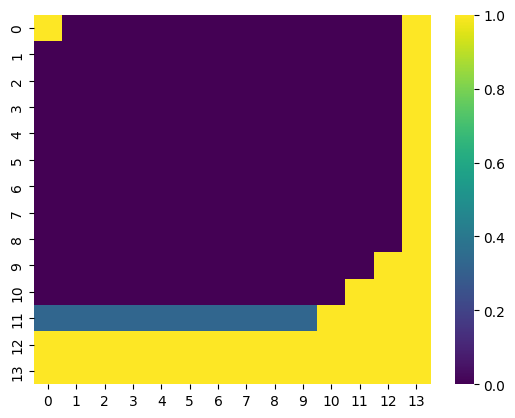

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
# Create a heatmap
sns.heatmap(t, cmap='viridis')
plt.show()